In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Utils
from scipy.optimize import minimize 
import Backtest as bt   
import matplotlib.dates as mdates


In [2]:
# SET GLOBAL VALUES
mu_target = 75 / 10000 # Target
w_current = np.array([0.4, 0.6]) # current strategy


In [3]:
bond = pd.read_csv("Data_clean/bond_returns.csv")
stock = pd.read_csv("Data_clean/6_Portfolios_ME_Prior_12_2_returns.csv")
bond, stock =bond[["Date", "10YrReturns"]], stock[["Date", "Market Return"]]
stock["Market Return"] = stock["Market Return"] /100  


In [4]:
data = pd.merge(bond,stock, how='left', on = "Date")


In [5]:
data

,Date,10YrReturns,Market Return
0,1990-01-31,-0.025702,-0.0724
1,1990-02-28,0.001547,0.0167
2,1990-03-31,-0.002251,0.0246
3,1990-04-30,-0.017928,-0.0266
4,1990-05-31,0.035839,0.0909
...,...,...,...
403,2023-08-31,-0.006376,-0.0190
404,2023-09-30,-0.035790,-0.0480
405,2023-10-31,-0.018635,-0.0261
406,2023-11-30,0.044330,0.0930


In [6]:
mu = np.mean([data["10YrReturns"],data["Market Return"]],axis=1)
sigma = np.cov([data["10YrReturns"],data["Market Return"]])
print("Mu", mu,"Sigma", sigma)


Mu [0.00432316 0.00930956] Sigma [[ 4.51987323e-04 -6.42279174e-05]
 [-6.42279174e-05  1.94512573e-03]]


In [7]:
# Current portfolio return and risk:
mu_4060 = w_current @ mu 
sigma_4060 =np.sqrt(w_current @ sigma @ w_current)

print("PF-value per month in bps", mu_4060 , "PF-std" , sigma_4060 )


PF-value per month in bps 0.007315000330233509 PF-std 0.02723479088829775


In [8]:
# Now for finding the weights that give optimal port with :
w_global = np.linalg.inv(sigma) @ np.ones(shape=2) / (np.ones(shape=2) @ np.linalg.inv(sigma) @ np.ones(shape=2))
mu_gmv = mu @ w_global
print("Global minimum variance pf",w_global, "global min var return", mu_gmv)

Global minimum variance pf [0.79560437 0.20439563] global min var return 0.005342360182836915


In [9]:
# minimum variance given target:
w_target, sigma_target = Utils.min_var(mu, sigma,mu_target) 
print("Weight:", w_target, "Minimum std of target mu",sigma_target)

Weight: [0.36289912 0.63710088] Minimum std of target mu 0.028624240153497005


In [10]:
# But if we consider the actual return from the pf:
# w_target, sigma_target = Utils.min_var(mu, sigma,mu_4060) 
# print("Weight:", w_target, "Minimum sigma of target mu",sigma_target)
# Actually really close to mean variance efficient
#BUT: IT DOES NOT DELIVER THE CORRESPONDING RETURN!
print("Return current PF", mu_4060, "!= Return Target",mu_target)

print("Reduction in risk in Variance:", (sigma_target -  sigma_4060)*10000 )

Return current PF 0.007315000330233509 != Return Target 0.0075
Reduction in risk in Variance: 13.89449265199256


In [11]:
# Plot mean variance frontier:
mu_vec = np.array([i*0.00025 for i in range(0,210)])
sigma_vec = [Utils.min_var(mu, sigma,i)[1] for i in mu_vec]


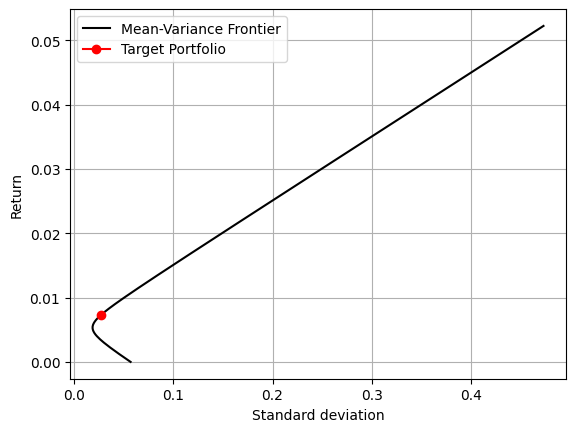

In [12]:
plt.plot(sigma_vec, mu_vec, color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_4060,mu_4060,marker='o', color = "red", label = "Target Portfolio")
plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

Introcude a risk free asset (Introduce RF from farma french)

In [13]:
RF = pd.read_csv("Data_clean/FF_cleaned.csv")
data = pd.merge(data.copy(),RF, 'left',on = "Date" )
data["RF"] = data["RF"] /100 # assumed this must hold

In [14]:
# We can then use functionality...
mu0 = np.mean(data["RF"])
mu_e = np.mean([data["10YrReturns"] - data["RF"],data["Market Return"]-data["RF"]],axis=1)
sigma_e = np.cov([data["10YrReturns"] - data["RF"],data["Market Return"] - data["RF"]])
mu_target_e = mu_target - mu0
mu_e, sigma_e

(array([0.00218468, 0.00717108]),
 array([[ 4.46243992e-04, -6.50726717e-05],
        [-6.50726717e-05,  1.94917955e-03]]))

In [15]:
w_target, sigma_target_e = Utils.min_var_rf(mu_e, sigma,mu_target_e) 
w0 = 1 - w_target @ np.ones(len(w_target))

print(w0, w_target, sigma_target)
# Got riskier.

-0.25605521160832545 [0.73113942 0.5249158 ] 0.028624240153497005


In [16]:
# Surprisingly risk is increased?
# Return:
mu_cml = np.array(w_target) @ np.array(mu) + w0*mu0 
print(mu_cml)

0.007500000000000002


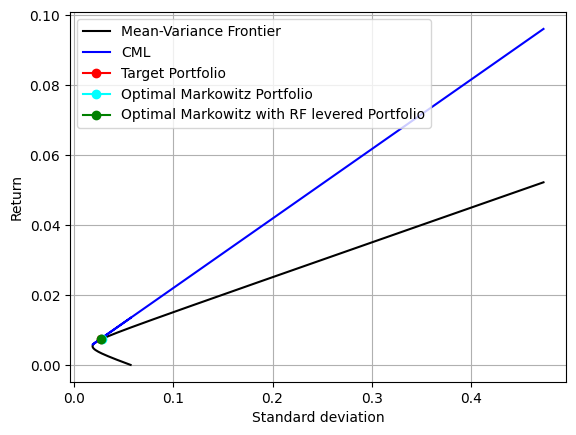

In [17]:
# Plot mean variance frontier:
cml = [ mu0 + np.sqrt(mu_e @ np.linalg.inv(sigma) @ mu_e) * i for i in sigma_vec]
plt.plot(sigma_vec, mu_vec, color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec, cml, color = "blue",label = "CML")
plt.plot(sigma_4060,mu_4060,marker='o', color = "red", label = "Target Portfolio")
plt.plot(sigma_target,mu_target,marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_target_e,mu_cml,marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")

plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

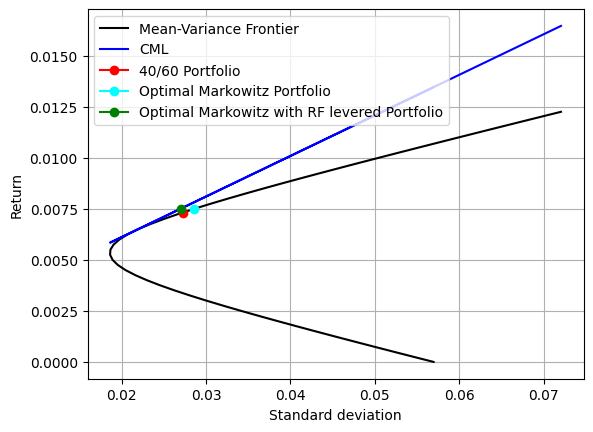

In [18]:
# close up:
# Plot mean variance frontier:
cml = [ mu0 + np.sqrt(mu_e @ np.linalg.inv(sigma) @ mu_e) * i for i in sigma_vec]
plt.plot(sigma_vec[:50], mu_vec[:50], color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec[:50], cml[:50], color = "blue",label = "CML")
plt.plot(sigma_4060,mu_4060,marker='o', color = "red", label = "40/60 Portfolio")
plt.plot(sigma_target,mu_target,marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_target_e,mu_cml,marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")

plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

Risk Parity

In [19]:
# try this packages - check doc? - (would be funny to try oneself)
import riskparityportfolio as rp
optimum_weights = rp.vanilla.design(Sigma = sigma, b = mu.reshape(-1,1), tol=0.0001, maxiter=50, method='spinu')
optimum_weights

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\riskparityportfolio\sca.py:10: UserWarning: not able to import quadprog. the successive convex optimizer wont work.
  warnings.warn(


array([0.66634524, 0.33365476])

In [20]:
mu.reshape(-1,1)

array([[0.00432316],
       [0.00930956]])

In [21]:
sigma_rp = np.sqrt(optimum_weights @ sigma @ optimum_weights)
mu_rp = mu @ optimum_weights


In [22]:
# Try with scipys' minimize - allow no shorting at first
# We must allow leverage. 
def constraint(w):
    return w @ np.ones(len(w)) - 1


In [23]:
# We try to match the volatility of the 40-60 portfolio
w0 = np.array([0.5,0.5])
res = minimize(fun = Utils.risk_parity_fun, x0 = w0, method = 'trust-constr', 
                   args =(sigma),
                   bounds = ((0,None),(0,None)),
                    constraints={'type': 'eq', 'fun': constraint})
w_rp = res.x
print("w",w_rp, "Sum of Squares", res.fun )

w [0.67474248 0.32525752] Sum of Squares 3.979138167330232e-17


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


In [24]:
# check of function: 
check = w_rp *  ( sigma @ w_rp) /np.sqrt(w_rp @ sigma @ w_rp)
check2 = np.sqrt(w_rp @ sigma @ w_rp) / len(w_rp)
pf_risk = np.sqrt(w_rp @ sigma @ w_rp)
print("Actual risk weight", check, "Target", check2, "Portfolio risk", pf_risk)
sigma_rp = np.sqrt(w_rp @ sigma @ w_rp)
mu_rp = mu @ w_rp

Actual risk weight [0.00978989 0.00978989] Target 0.00978988861173352 Portfolio risk 0.01957977722346704


In [25]:
# We then leverage by choosing leverage s.t.
lev = (mu_target_e ) / (w_rp @ mu_e )
print("leverage of", lev -1)
# We holdings: 
w_rp_lev = lev * w_rp
w0 = (1-w_rp_lev @ np.ones(2))
print(w0)
sigma_rp_lev, mu_rp_lev = np.sqrt(w_rp_lev @ sigma @w_rp_lev), mu @ w_rp_lev + w0*mu0
check = w_rp_lev *  ( sigma @ w_rp_lev) /np.sqrt(w_rp_lev @ sigma @ w_rp_lev)
check2 = np.sqrt(w_rp_lev @ sigma @ w_rp_lev) / len(w_rp_lev)
pf_risk = np.sqrt(w_rp_lev @ sigma @ w_rp_lev)
print("Actual risk weight", check, "Target", check2, "Portfolio risk", pf_risk)

leverage of 0.40850023200599095
-0.40850023200599095
Actual risk weight [0.01378906 0.01378906] Target 0.013789060380939471 Portfolio risk 0.027578120761878943


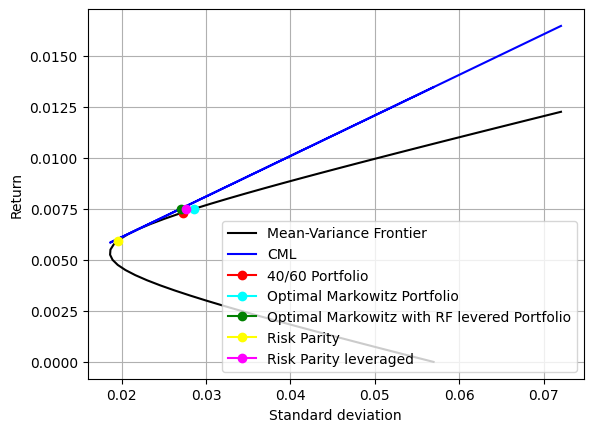

In [26]:
# Plot mean variance frontier:
cml = [ mu0 + np.sqrt(mu_e @ np.linalg.inv(sigma) @ mu_e) * i for i in sigma_vec]
plt.plot(sigma_vec[:50], mu_vec[:50], color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec[:50], cml[:50], color = "blue",label = "CML")
plt.plot(sigma_4060,mu_4060,marker='o', color = "red", label = "40/60 Portfolio")
plt.plot(sigma_target,mu_target,marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_target_e,mu_cml,marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")
plt.plot(sigma_rp,mu_rp,marker='o', color = "yellow", label = "Risk Parity")
plt.plot(sigma_rp_lev,mu_rp_lev,marker='o', color = "magenta", label = "Risk Parity leveraged")

plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

In [27]:
# Test weights:
test = Utils.get_weights(mu,sigma, mu_target,mu_e,sigma_e, mu_target_e)
print(test)

[array([0.4, 0.6]), array([0.36289912, 0.63710088]), array([0.73879193, 0.52258444]), array([0.67474248, 0.32525752]), array([0.95037494, 0.45812529])]


In [28]:
sigma_test, mu_test = [np.sqrt(w @ sigma @ w) for w in test],  [w @ mu for w in test]
mu_test[2] = mu_test[2] + (1-test[2] @ np.ones(2))*mu0 # Since we have holdings in w0 (mu is exess ret)
mu_test[4] = mu_test[4] + (1-test[4] @ np.ones(2))*mu0 # Since we have holdings in w0


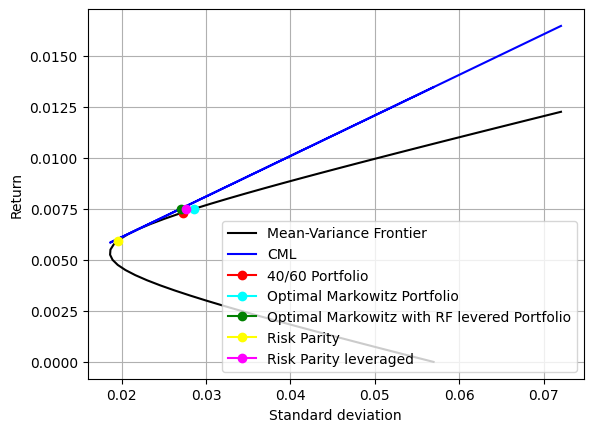

In [29]:
plt.plot(sigma_vec[:50], mu_vec[:50], color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec[:50], cml[:50], color = "blue",label = "CML")
plt.plot(sigma_test[0],mu_test[0],marker='o', color = "red", label = "40/60 Portfolio")
plt.plot(sigma_test[1],mu_test[1],marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_test[2],mu_test[2],marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")
plt.plot(sigma_test[3],mu_test[3],marker='o', color = "yellow", label = "Risk Parity")
plt.plot(sigma_test[4],mu_test[4],marker='o', color = "magenta", label = "Risk Parity leveraged")

plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

c:\Users\andre\Asset_allocation\Backtest.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data[j][k] = (1 +  w0 * data["RF"][k] + w1 * data["10YrReturns"][k] + w2 * data["Market Return"][k])*data[j][k-1]
c:\Users\andre\Asset_allocation\B

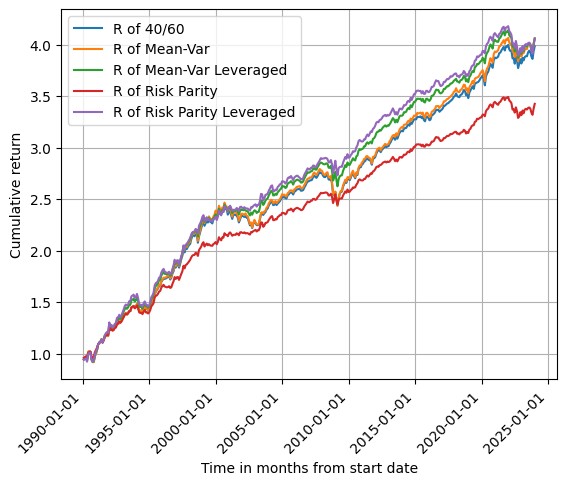

In [31]:
# test of backtest. 
test ,w0t,w1t,w2t= bt.backtest_naive(data, mu_target=mu_target)

["R_40/60", "R_MV", "R_MVL", "R_RP", "R_RPL"]
time = pd.date_range(data["Date"][0],data["Date"][len(data["Date"]) -1 ], freq = 'M')
fig, ax = plt.subplots()
ax.plot(time,data["R_40/60"], label="R of 40/60")
ax.plot(time,data["R_MV"], label="R of Mean-Var")
ax.plot(time,data["R_MVL"], label="R of Mean-Var Leveraged")
ax.plot(time,data["R_RP"], label="R of Risk Parity")
ax.plot(time,data["R_RPL"], label="R of Risk Parity Leveraged")
ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend()
plt.grid()
plt.xticks(rotation=45, ha='right')

plt.xlabel("Time in months from start date")
plt.ylabel("Cumulative return")
plt.show()

In [46]:
data["Date"][len(data["Date"]) -1 ]

'2023-12-31'

In [37]:
w0t*test["R_RPL"][len(data["Date"]) -2],w1t*test["R_RPL"][len(data["Date"]) -2],w2t * test["R_RPL"][len(data["Date"]) -2]

(np.float64(-0.40850023200599095),
 np.float64(0.9503749411023579),
 np.float64(0.4581252909036331))